In [1]:
import pypsa
import numpy as np
import random
import matplotlib.pyplot as plt, mpld3
import pandas as pd
random.seed(69)
network = pypsa.Network()
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Add 8 buses
for i in range(8):
    network.add("Bus","Bus {}".format(i))
network.buses.at[network.buses.index[0], 'x'] = 0
network.buses.at[network.buses.index[0], 'y'] = 5

network.buses.at[network.buses.index[1], 'x'] = 6
network.buses.at[network.buses.index[1], 'y'] = 5

network.buses.at[network.buses.index[2], 'x'] = 9
network.buses.at[network.buses.index[2], 'y'] = 5

network.buses.at[network.buses.index[3], 'x'] = 3
network.buses.at[network.buses.index[3], 'y'] = 2

network.buses.at[network.buses.index[4], 'x'] = 0
network.buses.at[network.buses.index[4], 'y'] = 0

network.buses.at[network.buses.index[5], 'x'] = 3
network.buses.at[network.buses.index[5], 'y'] = 0

network.buses.at[network.buses.index[6], 'x'] = 6
network.buses.at[network.buses.index[6], 'y'] = 0

network.buses.at[network.buses.index[7], 'x'] = 9
network.buses.at[network.buses.index[7], 'y'] = 0
edges = [(0,1),(0,3),(0,4),(0,5),(1,3),(1,7),(1,2),(2,6),(2,7),(3,4),(3,5),(3,6),(5,6),(6,7)]
for i in range(len(edges)):
    network.add("Line","Line {}".format(i),
                bus0="Bus {}".format(edges[i][0]),
                bus1="Bus {}".format(edges[i][1]),
                x=0.0001,
                s_nom=60)

#add a generator at bus 2
network.add("Generator","Gen 2",
            bus="Bus 2",
            p_nom=300,
            marginal_cost=random.randint(25,75))
#add a generator at bus 3
network.add("Generator","Gen 3",
            bus="Bus 3",
            p_nom=300,
            marginal_cost=random.randint(25,75))
#add a generator at bus 4
network.add("Generator","Gen 4",
            bus="Bus 4",
            p_nom=300,
            marginal_cost=random.randint(25,75))
#add loads
for i in [0,1,5,6,7]:
    network.add("Load",f"Load {i}",
                bus=f"Bus {i}",
                p_set=random.randint(25,125))


In [3]:
busValue = list(network.buses.index)
lineValue = list(network.lines.index)
mpld3.enable_notebook()
def plot_stuff():
    color = network.buses_t.p.squeeze()
    line_color = network.lines_t.p0.abs().squeeze()

    fig, ax = plt.subplots(figsize=(12, 6))
    data = network.plot(bus_colors=color, bus_cmap=plt.cm.RdYlGn,line_cmap = plt.cm.RdYlGn,line_colors = line_color, line_widths = 5.0, bus_sizes = .1)

    busTooltip = mpld3.plugins.PointHTMLTooltip(data[0], busValue,0,0,-50)
    lineTooltip = mpld3.plugins.PointHTMLTooltip(data[1], lineValue, 0, 0, -50)
    fileName = "network" + str(3) + ".html" 
    mpld3.plugins.connect(fig,lineTooltip)
    mpld3.plugins.connect(fig,busTooltip)
    mpld3.save_html(fig, fileName)

In [4]:
%%capture
network.lopf(pyomo=False,solver_name='gurobi')

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.19s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver
INFO:pypsa.linopf:Optimization successful. Objective value: 1.23e+04


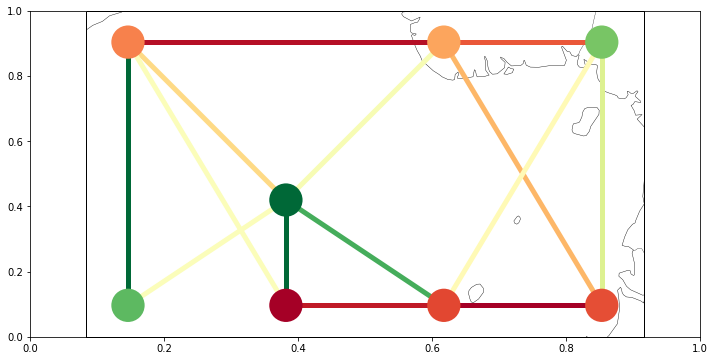

In [5]:
plot_stuff()

In [6]:
# Cheap generator 1 cannot be fully dispatched because of network constraints,
# so expensive generator 0 also has to dispatch
network.generators_t.p

,Gen 2,Gen 3,Gen 4
now,84.0,138.666667,93.333333


In [7]:
# network flows
(network.lines_t.p0)

,Line 0,Line 1,Line 2,Line 3,Line 4,Line 5,Line 6,Line 7,Line 8,Line 9,Line 10,Line 11,Line 12,Line 13
now,7.333333,-26.666667,-60.0,33.333333,-34.0,22.916667,-14.583333,31.916667,37.5,-33.333333,60.0,51.333333,-8.666667,5.583333


In [8]:
#Line 1 is congested
network.lines_t.p0/network.lines.s_nom

,Line 0,Line 1,Line 2,Line 3,Line 4,Line 5,Line 6,Line 7,Line 8,Line 9,Line 10,Line 11,Line 12,Line 13
now,0.122222,-0.444444,-1.0,0.555556,-0.566667,0.381944,-0.243056,0.531944,0.625,-0.555556,1.0,0.855556,-0.144444,0.093056


In [9]:
#Power flows towards lower voltage angles
(network.buses_t.p)

,Bus 0,Bus 1,Bus 2,Bus 3,Bus 4,Bus 5,Bus 6,Bus 7
now,-46.0,-33.0,84.0,138.666667,93.333333,-102.0,-69.0,-66.0


In [10]:
network.loads.columns

Index(['bus', 'carrier', 'type', 'p_set', 'q_set', 'sign'], dtype='object', name='attribute')

In [101]:
def snom_over_load(row):
    bus = row['bus']
    load = row['p_set']
    return network.lines[(network.lines['bus0'] == bus) | (network.lines['bus1'] == bus)]['s_nom'].sum() / load
pop = network.loads.apply(lambda x: snom_over_load(x),axis=1).sort_values(ascending = True)


In [110]:
network.lines.loc['Line 0'][['bus0','bus1']].values.delete('Bus 0')

AttributeError: 'numpy.ndarray' object has no attribute 'delete'

In [117]:
# network.loads.apply(lambda x: snom_over_load(x),axis=1).sort_values(ascending = True)

network.loads['bus'].isin(['Bus 0','Bus 5'])

Load 0     True
Load 1    False
Load 5     True
Load 6    False
Load 7    False
Name: bus, dtype: bool

In [116]:
if np.array([]):
    print('a')

In [12]:
pop = network.lines_t.p0.T.merge(network.lines,left_index=True,right_index=True)[['bus0','bus1','now']]
# pop = pop.groupby('bus0').sum().merge(pop.groupby('bus1').sum(),how='outer',left_index=True,right_index=True)
# pop.fillna(0,inplace=True)
# pop
# def get_line_counts
pop.bus0.value_counts()['Bus 0']

4

In [13]:
list(network.lines.loc['Line 0'][['bus0','bus1']])

['Bus 0', 'Bus 1']

In [30]:
pop = network.lines.loc['Line 0'][['bus0','bus1']].apply(lambda x: re.sub(r'Bus','Load',x))
network.loads.loc[pop]
import re



attribute,bus,carrier,type,p_set,q_set,sign
Load 0,Bus 0,,,46.0,0.0,-1.0
Load 1,Bus 1,,,33.0,0.0,-1.0


In [15]:
%%capture
network.remove('Line','Line 3')
network.loads.apply(lambda x: get_snom_bus(x),axis=1)
# network.lopf(pyomo=False,solver_name='gurobi')


NameError: name 'get_snom_bus' is not defined

In [16]:
network.loads.apply(lambda x: snom_over_load(x),axis=1)

Load 0    3.913043
Load 1    7.272727
Load 5    1.176471
Load 6    3.478261
Load 7    2.727273
dtype: float64

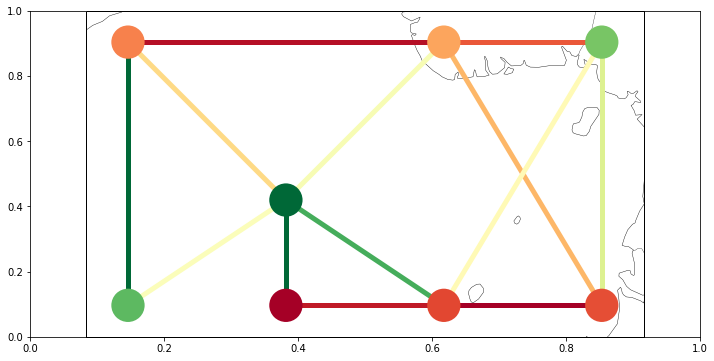

In [17]:
plot_stuff()

In [18]:
#Cheap generator 1 cannot be fully dispatched because of network constraints,
#so expensive generator 0 also has to dispatch
network.generators_t.p

,Gen 2,Gen 3,Gen 4
now,84.0,138.666667,93.333333


In [19]:
#network flows
(network.lines_t.p0)

,Line 0,Line 1,Line 2,Line 4,Line 5,Line 6,Line 7,Line 8,Line 9,Line 10,Line 11,Line 12,Line 13
now,7.333333,-26.666667,-60.0,-34.0,22.916667,-14.583333,31.916667,37.5,-33.333333,60.0,51.333333,-8.666667,5.583333


In [20]:
network.lines

attribute,bus0,bus1,type,x,r,g,b,s_nom,s_nom_extendable,s_nom_min,...,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu,x_pu_eff,r_pu_eff,s_nom_opt,v_nom
Line 0,Bus 0,Bus 1,,0.0001,0.0,0.0,0.0,60.0,False,0.0,...,inf,0,0.0001,0.0,0.0,0.0,0.0001,0.0,60.0,1.0
Line 1,Bus 0,Bus 3,,0.0001,0.0,0.0,0.0,60.0,False,0.0,...,inf,0,0.0001,0.0,0.0,0.0,0.0001,0.0,60.0,1.0
Line 2,Bus 0,Bus 4,,0.0001,0.0,0.0,0.0,60.0,False,0.0,...,inf,0,0.0001,0.0,0.0,0.0,0.0001,0.0,60.0,1.0
Line 4,Bus 1,Bus 3,,0.0001,0.0,0.0,0.0,60.0,False,0.0,...,inf,0,0.0001,0.0,0.0,0.0,0.0001,0.0,60.0,1.0
Line 5,Bus 1,Bus 7,,0.0001,0.0,0.0,0.0,60.0,False,0.0,...,inf,0,0.0001,0.0,0.0,0.0,0.0001,0.0,60.0,1.0
Line 6,Bus 1,Bus 2,,0.0001,0.0,0.0,0.0,60.0,False,0.0,...,inf,0,0.0001,0.0,0.0,0.0,0.0001,0.0,60.0,1.0
Line 7,Bus 2,Bus 6,,0.0001,0.0,0.0,0.0,60.0,False,0.0,...,inf,0,0.0001,0.0,0.0,0.0,0.0001,0.0,60.0,1.0
Line 8,Bus 2,Bus 7,,0.0001,0.0,0.0,0.0,60.0,False,0.0,...,inf,0,0.0001,0.0,0.0,0.0,0.0001,0.0,60.0,1.0
Line 9,Bus 3,Bus 4,,0.0001,0.0,0.0,0.0,60.0,False,0.0,...,inf,0,0.0001,0.0,0.0,0.0,0.0001,0.0,60.0,1.0
Line 10,Bus 3,Bus 5,,0.0001,0.0,0.0,0.0,60.0,False,0.0,...,inf,0,0.0001,0.0,0.0,0.0,0.0001,0.0,60.0,1.0


In [21]:
network.loads['p_set'].sum()

316.0

In [22]:
busValue = list(network.buses.index)
lineValue = list(network.lines.index)
def plot_stuff():
    color = network.buses_t.p.squeeze()


    fig, ax = plt.subplots(figsize=(12, 6))
    data = network.plot(bus_colors=color, bus_cmap=plt.cm.RdYlGn, line_widths = 5.0, bus_sizes = .1)
    
    busTooltip = mpld3.plugins.PointHTMLTooltip(data[0], busValue,0,0,-50,"body{color: black;}")
    lineTooltip = mpld3.plugins.PointHTMLTooltip(data[1], lineValue, 0, 0, -50)
    fileName = "network" + str(3) + ".html" 
    mpld3.plugins.connect(fig,lineTooltip)
    mpld3.plugins.connect(fig,busTooltip)
    mpld3.save_html(fig, fileName)


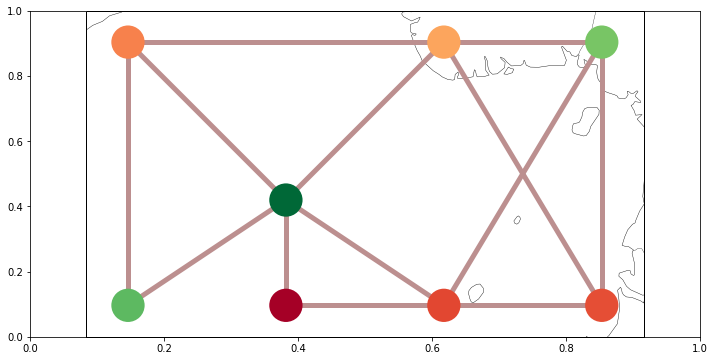

In [23]:
plot_stuff()